In [27]:
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

In [28]:
train_df = pd.read_csv('train_copy.csv')
test_df = pd.read_csv('test_copy.csv')
test_df = test_df[train_df.columns.tolist()]

In [29]:
categorical_cols = train_df.select_dtypes(include=['object']).columns.tolist()
numerical_cols = train_df.select_dtypes(include=['number']).columns.tolist()

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt


def check_normalization(df):
    for col in df.columns:
        if df[col].max() > 1 or df[col].min() < 0:
            print(str(col) + ' is not normalized')
        else:
            print(str(col) + ' is normalized')


check_normalization(train_df[numerical_cols])

age is not normalized
wage_per_hour is not normalized
capital_gains is not normalized
capital_losses is not normalized
stock_dividends is not normalized
num_emp is not normalized
own_or_self is not normalized
weeks_worked is not normalized
year is not normalized
income_50k is normalized


In [31]:
X_train = train_df.drop('income_50k', axis=1)
y_train = train_df['income_50k']
X_test = test_df.drop('income_50k', axis=1)
y_test = test_df['income_50k']
numerical_cols = list(set(numerical_cols) - {'income_50k'})

In [32]:
# Create the preprocessor to encode categorical variables and scale numerical variables
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
        ('num', StandardScaler(), numerical_cols)])

# Transform the train and test data
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

In [33]:
train_df.groupby('income_50k').count()

,age,wage_per_hour,capital_gains,capital_losses,stock_dividends,num_emp,own_or_self,weeks_worked,year,class_worker,...,major_occ_code,race,sex,union_member,full_or_part_emp,tax_filer_stat,det_hh_summ,mig_same,fam_under_18,citizenship
income_50k,,,,,,,,,,,,,,,,,,,,,
0,187141,187141,187141,187141,187141,187141,187141,187141,187141,187141,...,187141,187141,187141,187141,187141,187141,187141,187141,187141,187141
1,12382,12382,12382,12382,12382,12382,12382,12382,12382,12382,...,12382,12382,12382,12382,12382,12382,12382,12382,12382,12382


### Noticed that the traget data is highly unbalanced. Since some models are sensitive for unbalanced class, then it may lead to overfitting problems. To balance the dataset, we shall use oversampling.

In [34]:
# Instantiate SMOTE
rus = RandomUnderSampler(random_state=42)
# Resample training data
X_train_res, y_train_res = rus.fit_resample(X_train, y_train)

In [35]:
# Define the models
models = [
    {
        'name': 'Logistic Regression',
        'estimator': LogisticRegression(max_iter=1000),
        'hyperparameters': {
            'C': [0.1, 1, 10],
            'penalty': ['l1', 'l2'],
        }
    },
    {
        'name': 'K-Nearest Neighbors',
        'estimator': KNeighborsClassifier(),
        'hyperparameters': {
            'n_neighbors': [5, 10, 20],
        }
    },
    {
        'name': 'Decision Tree',
        'estimator': DecisionTreeClassifier(),
        'hyperparameters': {
            'max_depth': [5, 10, 20],
            'min_samples_split': [2, 5, 10],
        }
    },
    {
        'name': 'Random Forest',
        'estimator': RandomForestClassifier(),
        'hyperparameters': {
            'n_estimators': [10, 50, 100],
            'max_depth': [5, 10, 20],
            'min_samples_split': [2, 5, 10],
        }
    },
    {
        'name': 'AdaBoost',
        'estimator': AdaBoostClassifier(),
        'hyperparameters': {
            'n_estimators': [10, 50, 100],
            'learning_rate': [0.1, 0.5, 1.0],
        }
    }

]

In [36]:
# Loop through the models and perform cross-validation to select model parameters
for model in models:
    print(model['name'])
    grid_search = GridSearchCV(model['estimator'], model['hyperparameters'], cv=5)
    grid_search.fit(X_train_res, y_train_res)
    print('Best parameters:', grid_search.best_params_)
    print('Best score:', grid_search.best_score_)
    print()
    model['best_estimator'] = grid_search.best_estimator_

Logistic Regression


/Users/davidmao/opt/anaconda3/envs/tensorflow/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
15 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/davidmao/opt/anaconda3/envs/tensorflow/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/davidmao/opt/anaconda3/envs/tensorflow/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/davidmao/opt/anaconda3/envs/tens

Best parameters: {'C': 10, 'penalty': 'l2'}
Best score: 0.8687204145461687

K-Nearest Neighbors
Best parameters: {'n_neighbors': 20}
Best score: 0.854264023664123

Decision Tree
Best parameters: {'max_depth': 10, 'min_samples_split': 2}
Best score: 0.8509123319787587

Random Forest
Best parameters: {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 50}
Best score: 0.8723951590834295

AdaBoost
Best parameters: {'learning_rate': 1.0, 'n_estimators': 100}
Best score: 0.8715875595704631



In [58]:
models_name_list = [model['name'] for model in models]
pred_output = pd.DataFrame(y_test)

In [68]:
for model in models:
    model_name = model['name']
    print(model_name)
    y_pred = model['best_estimator'].predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Test accuracy: {accuracy:.2f}')
    pred_output[str(model_name)] = y_pred
    print()


Logistic Regression
Test accuracy: 0.84

K-Nearest Neighbors
Test accuracy: 0.83

Decision Tree
Test accuracy: 0.83

Random Forest
Test accuracy: 0.84

AdaBoost
Test accuracy: 0.85



In [69]:
pred_output

,income_50k,Logistic Regressionpred,K-Nearest Neighborspred,Decision Treepred,Random Forestpred,AdaBoostpred,Logistic Regression,K-Nearest Neighbors,Decision Tree,Random Forest,AdaBoost
0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,1,0,0,1,0,1,0
2,0,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,1,0,0,0,0
4,0,1,1,1,0,1,1,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...
99757,0,0,0,0,0,0,0,0,0,0,0
99758,0,0,1,1,0,0,0,1,1,0,0
99759,0,0,0,0,0,0,0,0,0,0,0
99760,0,1,1,1,1,1,1,1,1,1,1


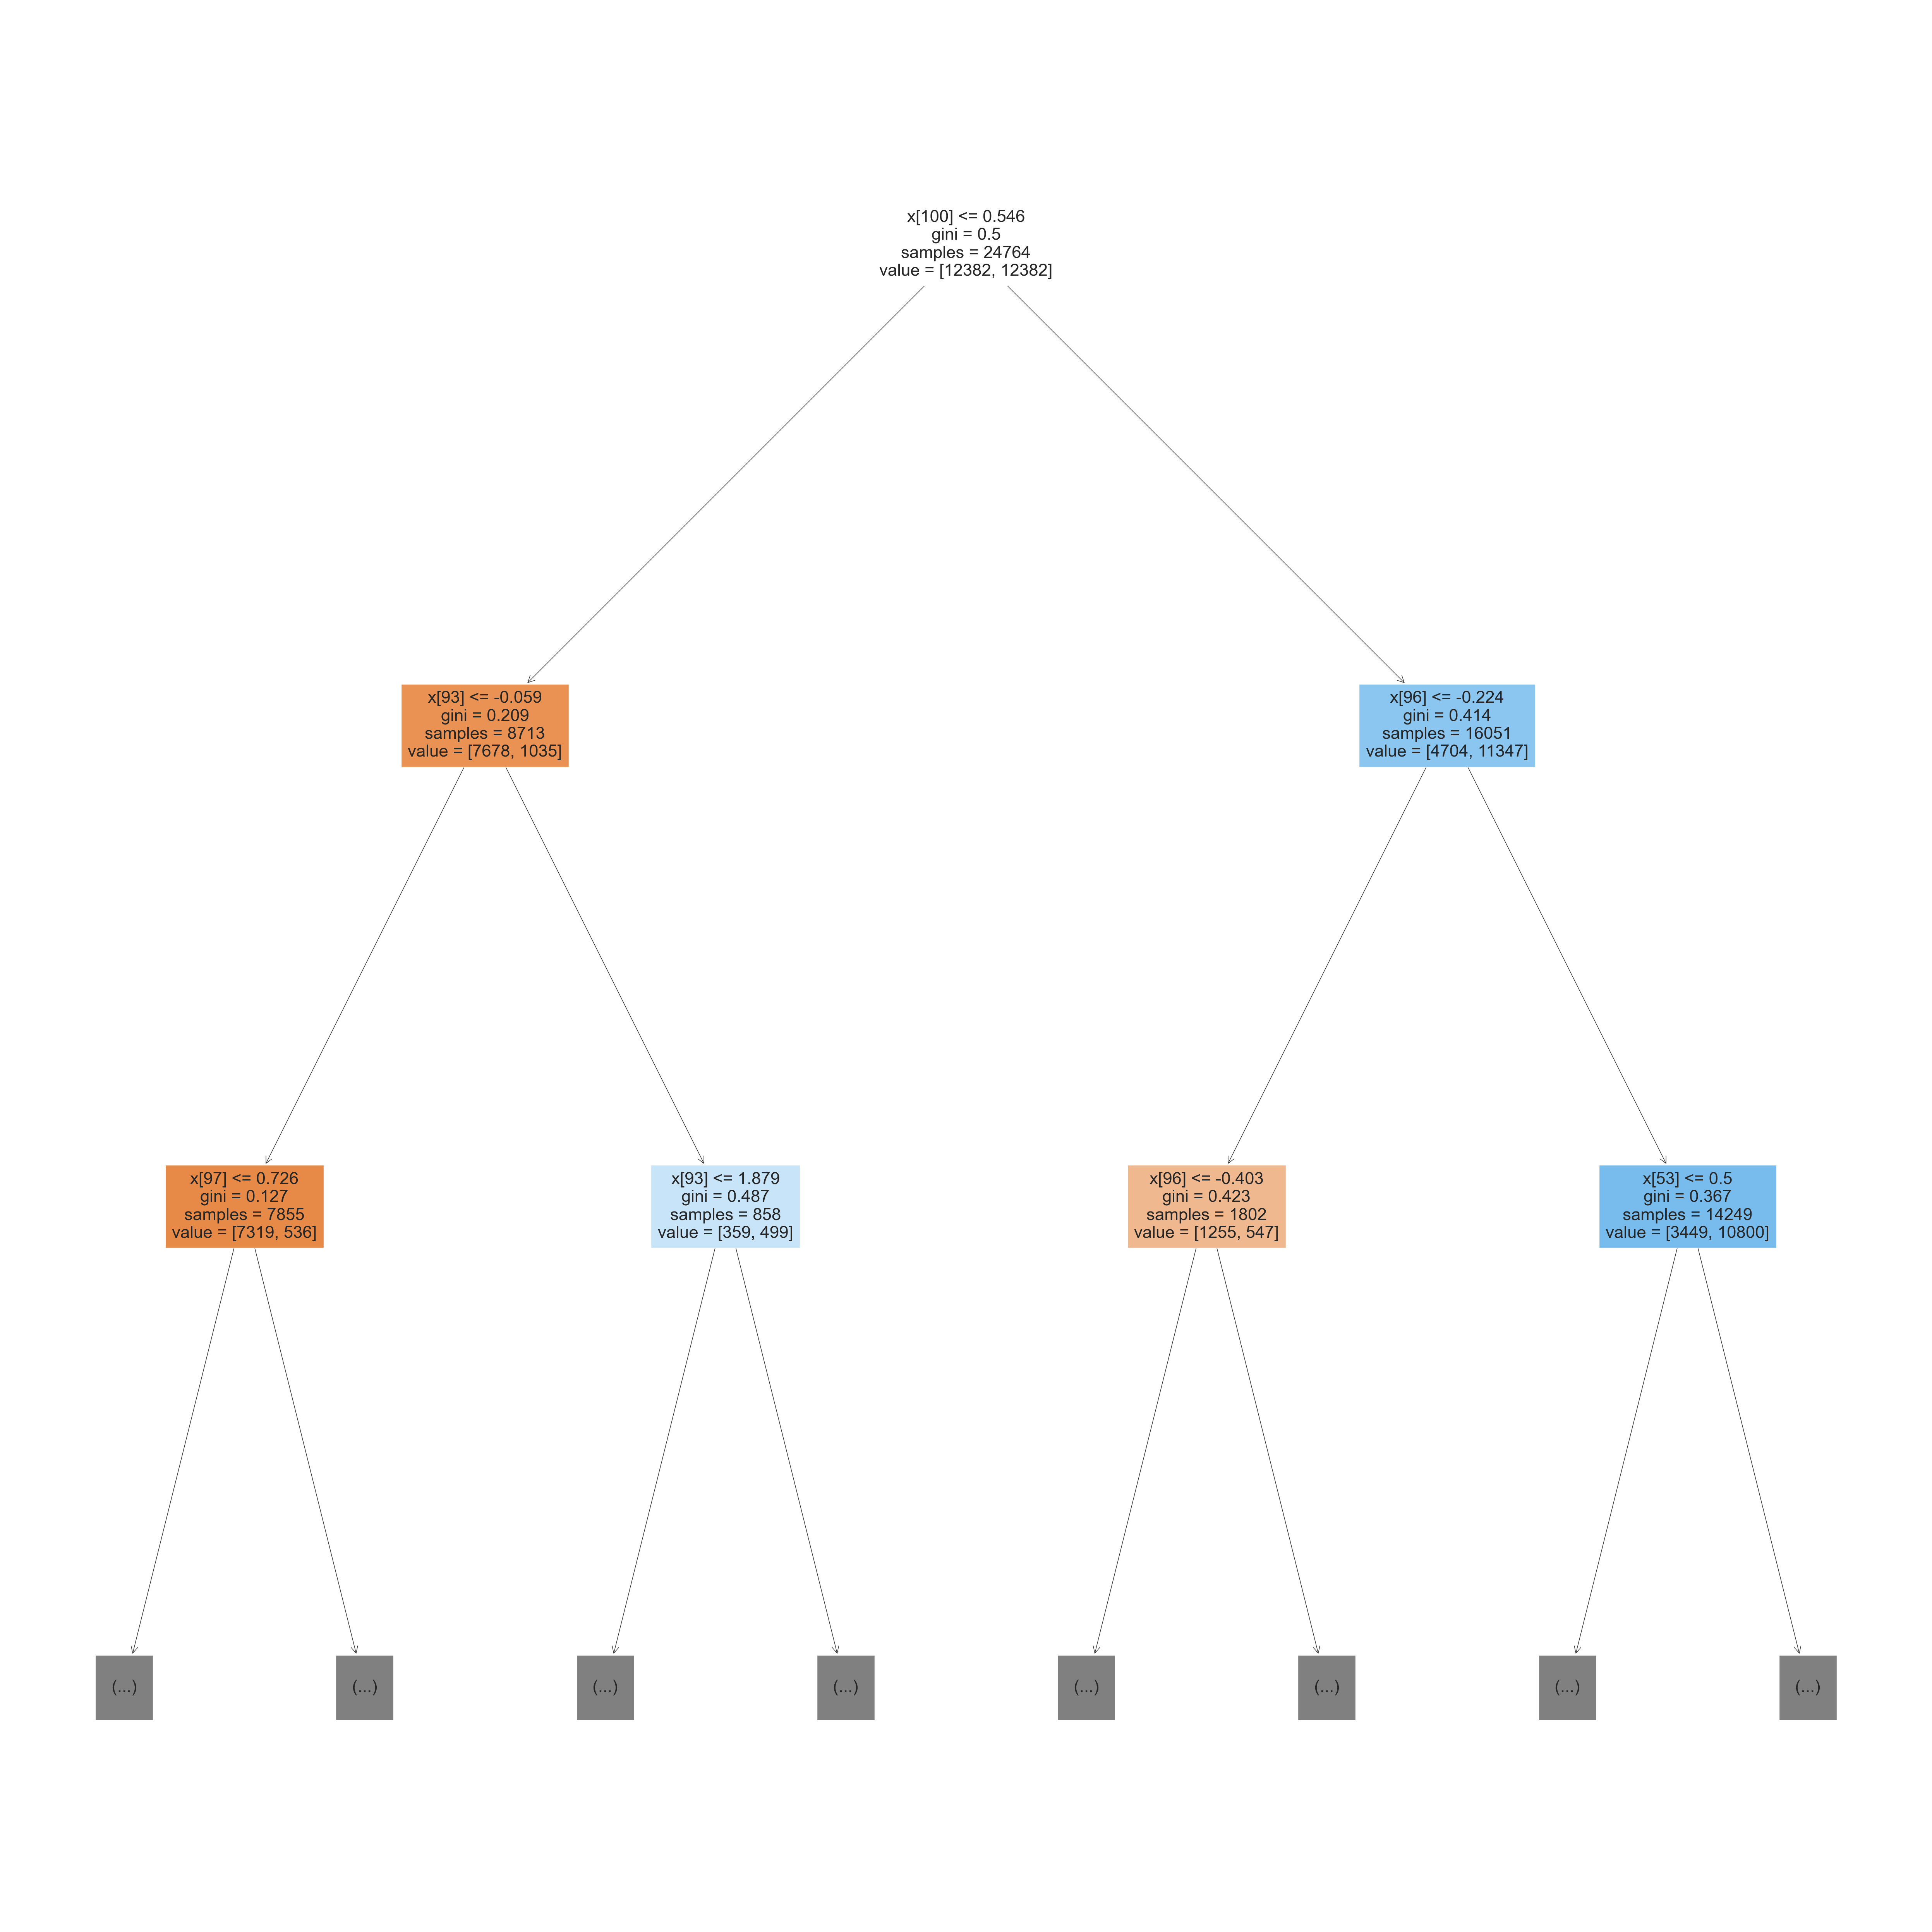

In [70]:
plt.figure(figsize=(50, 50))
plot_tree(models[2]['best_estimator'],filled=True,max_depth=2)
plt.tight_layout()
plt.show()

In [66]:
#pred_output.to_csv('y_true_vs_y_pred.csv',index=False)

In [71]:
models_name_list

['Logistic Regression',
 'K-Nearest Neighbors',
 'Decision Tree',
 'Random Forest',
 'AdaBoost']

In [75]:
y_true = pred_output['income_50k']
predictions = pred_output[models_name_list].T.to_numpy()

In [76]:
from sklearn.metrics import classification_report

def model_accuracy_check(models, y_true, y_pred_array, plot_cm=False, show_report=False):
    accuracies = []
    for i in range(len(models)):
        acc = accuracy_score(y_true, y_pred_array[i])
        accuracies.append(acc)
        print(f'Model {models[i]}: Accuracy = {np.round(acc, 2)}')
    sns.barplot(x=models, y=accuracies)
    plt.xlabel('Models')
    plt.ylabel('Accuracy')
    plt.title('Accuracy of Classification Models')
    plt.show()
    print()
    accuracies_df = pd.DataFrame(
        {'Modle': ['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest', 'AdaBoost'], 'Accuracy': accuracies})
    if plot_cm == True:
        print('Confusion Matrix Plots: \n')
        for i in range(len(models)):
            cm = confusion_matrix(y_true, predictions[i])
            print(f'Model {models[i]}:')
            print(cm)
            sns.heatmap(cm, annot=True, cmap='coolwarm')
            plt.xlabel('Predicted')
            plt.ylabel('True')
            plt.title('Confusion Matrix: ' + str(models[i]))
            plt.show()
    print()
    if show_report == True:
        for i in range(len(models)):
            cr = classification_report(y_true, predictions[i])
            print(f'Classification Report: {models[i]}')
            print(cr)
    return accuracies_df



Model Logistic Regression: Accuracy = 0.84
Model K-Nearest Neighbors: Accuracy = 0.83
Model Decision Tree: Accuracy = 0.83
Model Random Forest: Accuracy = 0.84
Model AdaBoost: Accuracy = 0.85


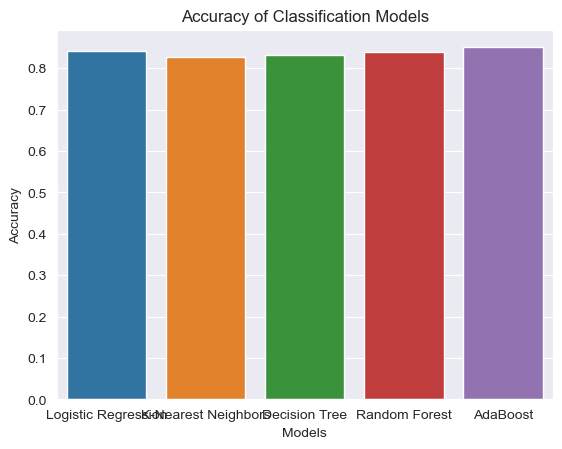


Confusion Matrix Plots: 

Model Logistic Regression:
[[78494 15082]
 [  620  5566]]


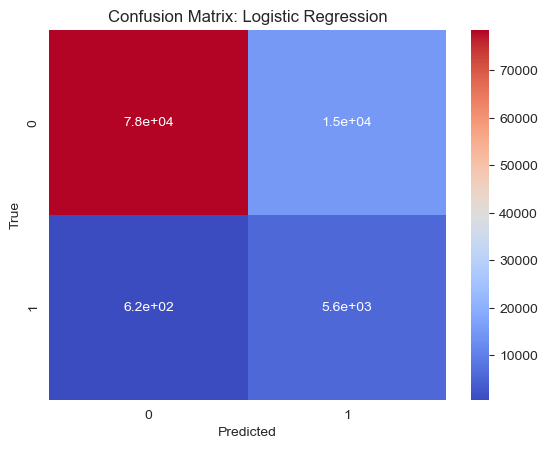

Model K-Nearest Neighbors:
[[76922 16654]
 [  661  5525]]


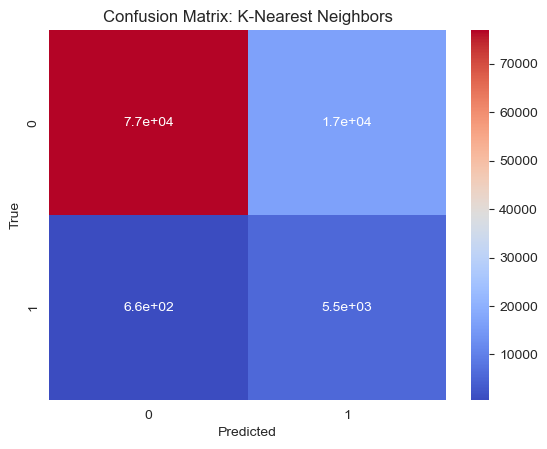

Model Decision Tree:
[[77706 15870]
 [  771  5415]]


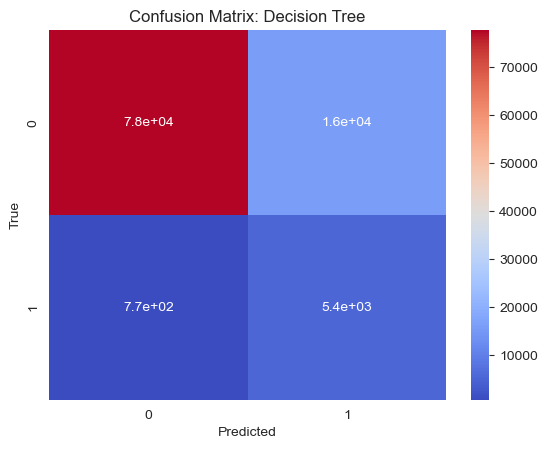

Model Random Forest:
[[77968 15608]
 [  544  5642]]


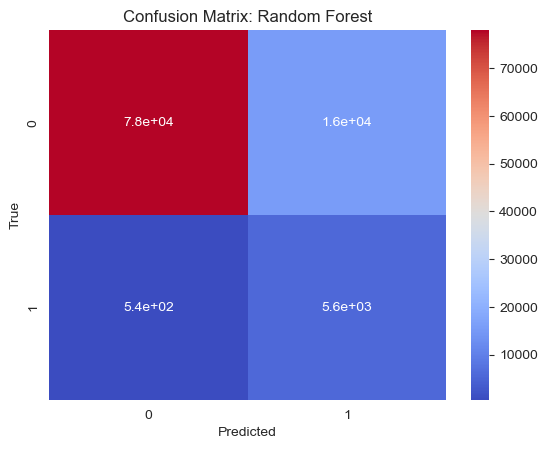

Model AdaBoost:
[[79309 14267]
 [  639  5547]]


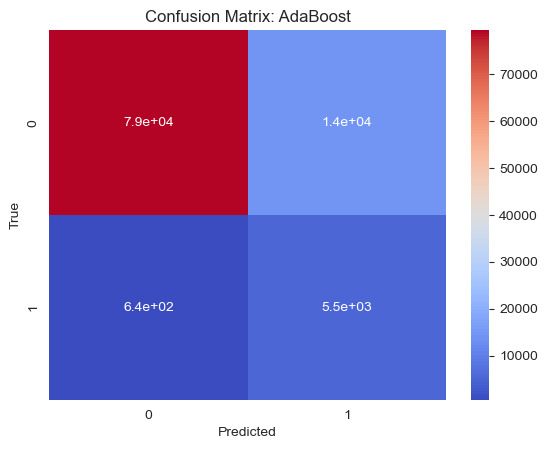

In [79]:
accuracies_df = model_accuracy_check(models_name_list,y_true,predictions,plot_cm=True)
